# RNA2seg

**RNA2seg: a generalist model for cell segmentation in image-based spatial transcriptomics** (2025)

Thomas Defard, Alice Blondel, Anthony Coleon, Guilherme Dias de Melo, Thomas Walter, Florian Mueller


Teacher: Alice Blonder (Mines)

Helper: Gaëlle Letort (DSCB, Institut Pasteur)


## RNA2seg Overview

**RNA2seg** is a deep learning-based segmentation model designed to improve cell segmentation in **Imaging-based Spatial Transcriptomics (IST)**. Traditional IST methods rely on nuclear and membrane staining to define cell boundaries, but segmentation can be challenging due to the variable quality of membrane markers.  

RNA2seg addresses this issue by integrating an **arbitrary number of staining channels** along with **RNA spatial distributions** to enhance segmentation accuracy, particularly in regions with low-quality membrane staining. It is built on **SpatialData**, enabling seamless processing and analysis of spatial transcriptomics data. 

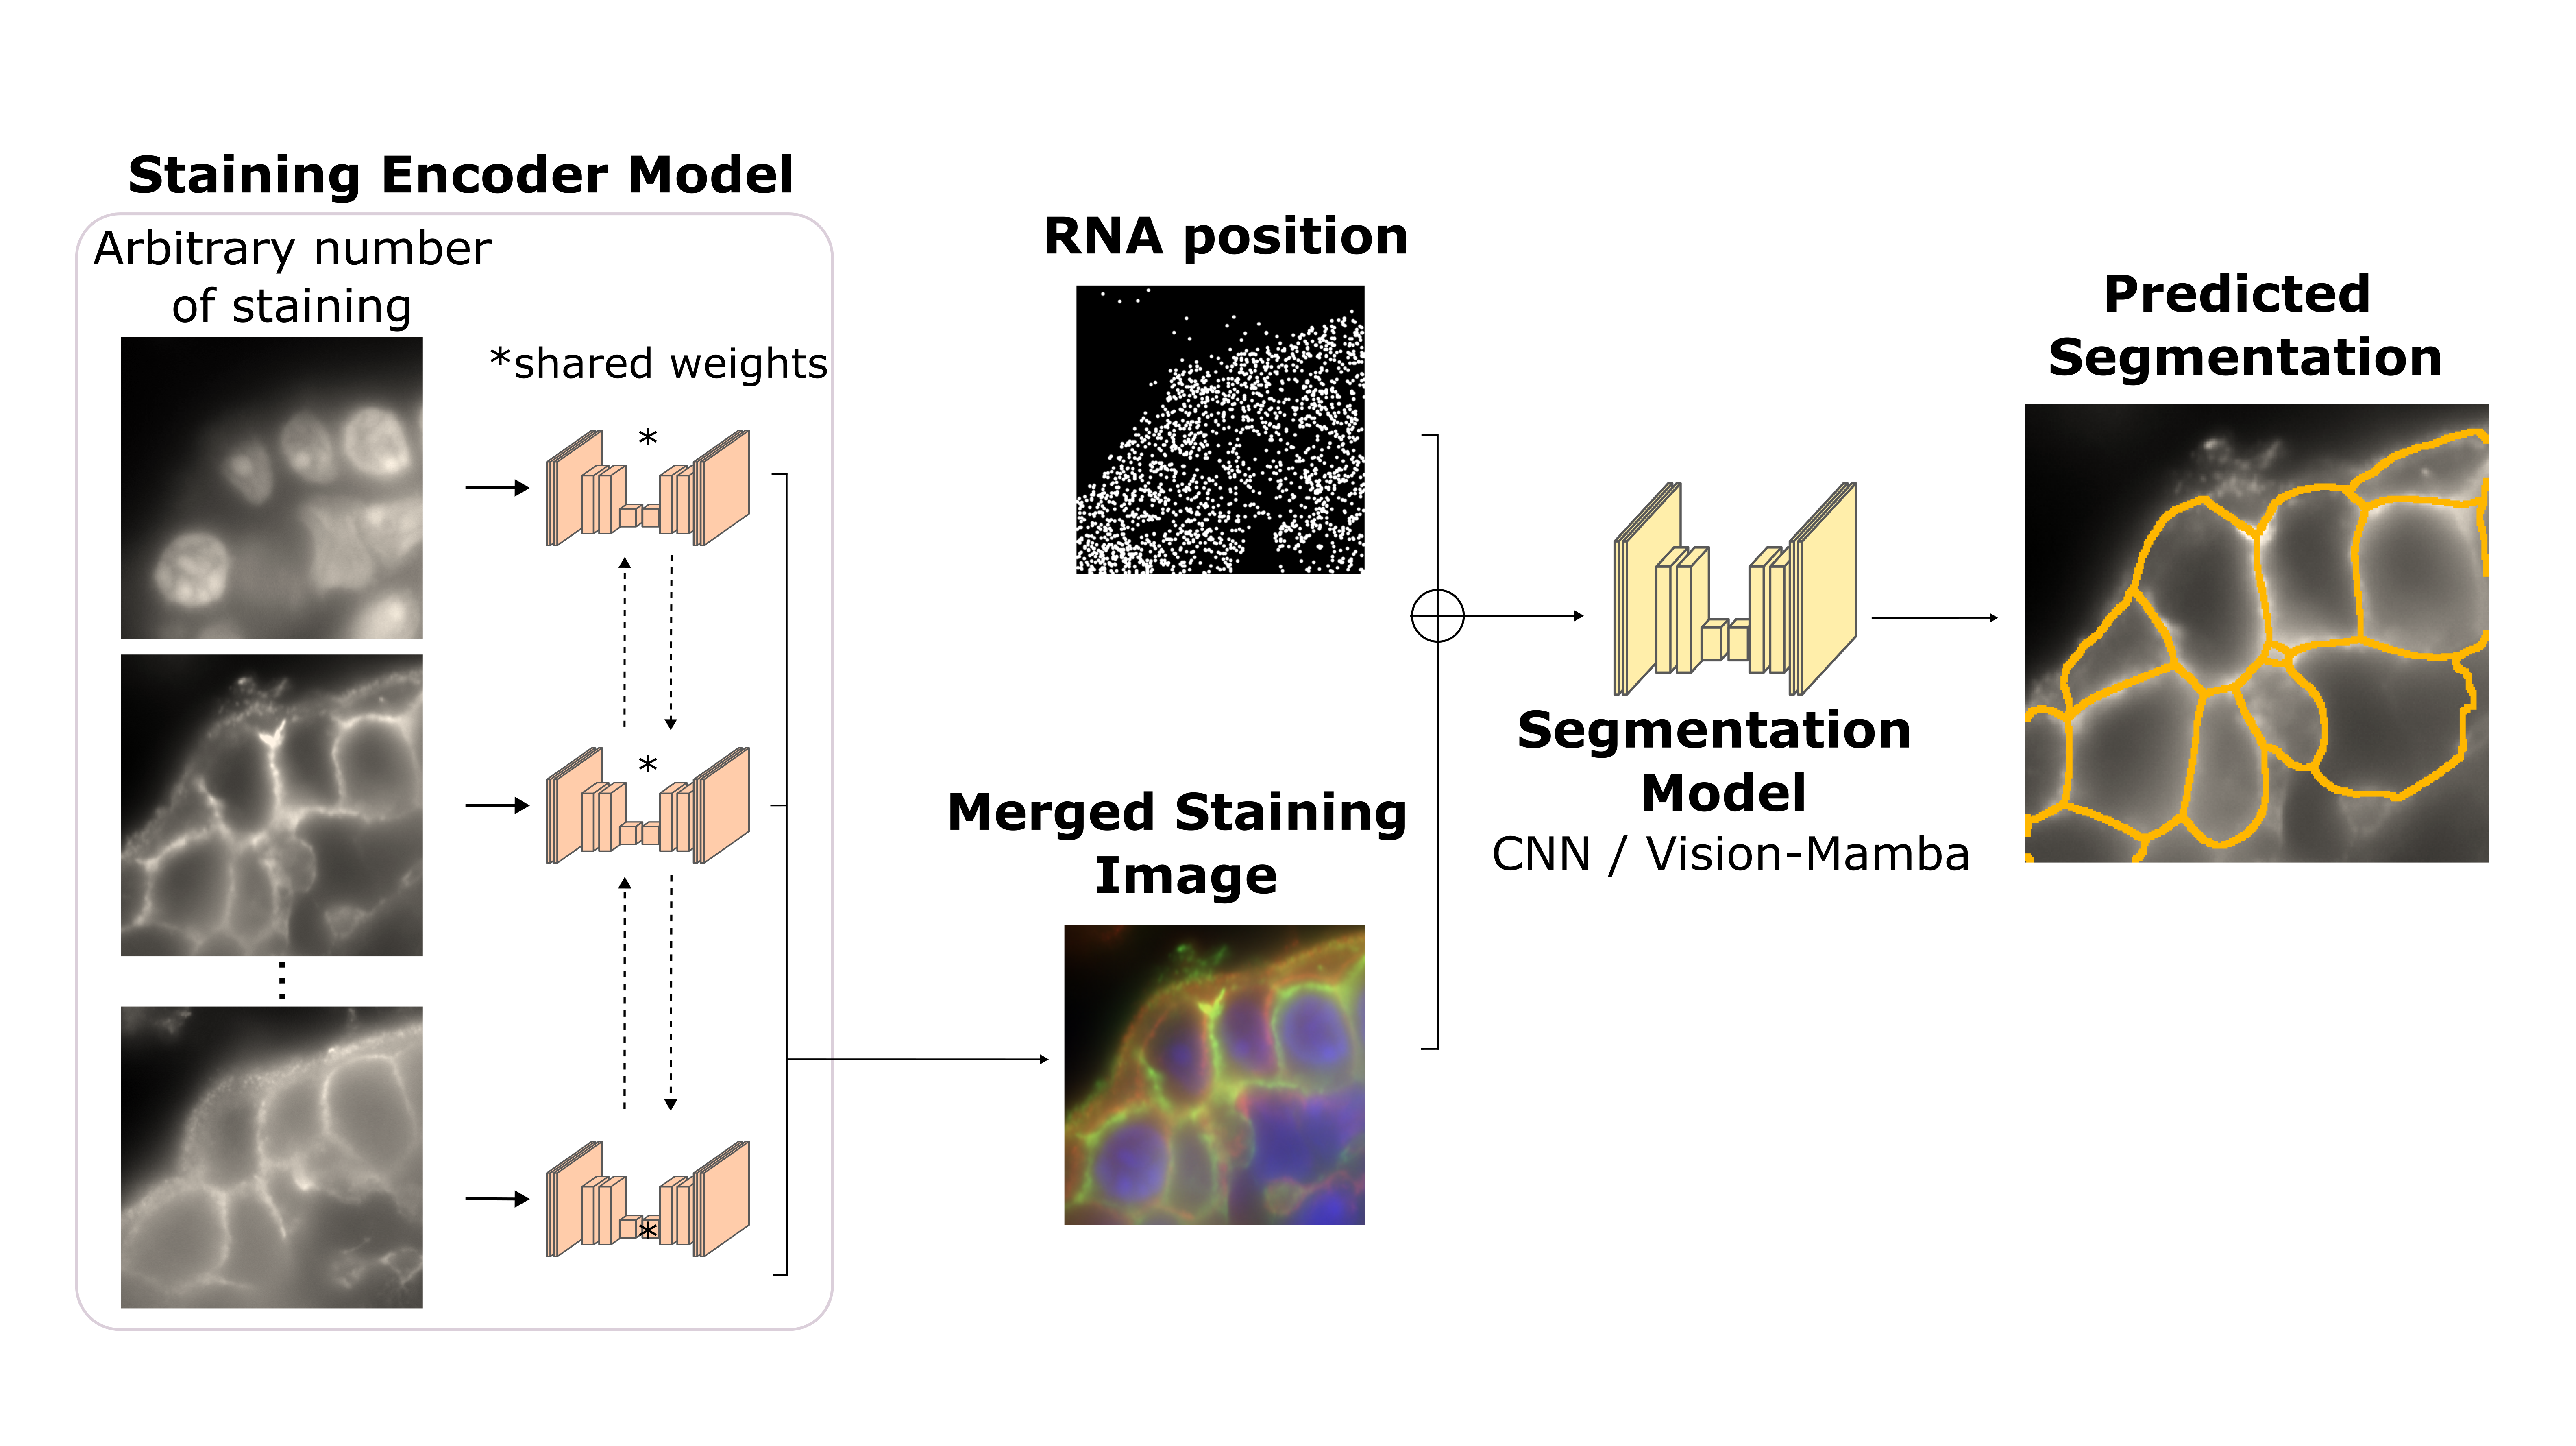

Figure 1 from RNA2seg paper. 

**Key Features**:

- **Multi-channel input**: Leverages nuclear, membrane, and RNA spatial data.
- **Zero-shot learning**: Multi-dataset training (7 organs, 4 millions cells) + Generalization to unseen datasets without requiring manual annotations.
- **Built on SpatialData**: Ensures compatibility with modern spatial transcriptomics pipelines.

**Useful links:**

- RNA2seg github: https://github.com/fish-quant/rna2seg
- RNA2seg documentation: https://rna2seg.readthedocs.io/en/latest/
- RNA2seg paper: https://www.biorxiv.org/content/10.1101/2025.03.03.641259v3.full.pdf

**Available models** :
- The default pretrained **RNA2seg** model is available via the ```pretrained_model``` argument in the ```RNA2seg``` class.  
  This model is trained on **CosMx** and **MERFISH** datasets across seven different human organs: *breast*, *colon*, *lung*, *melanoma*, *uterine*, *prostate*, and *ovarian*.

```python
rna2seg = RNA2seg(
    device,
    net='unet',
    flow_threshold = 0.9,
    cellbound_flow_threshold = 0.4,
    pretrained_model = "default_pretrained"
)
```

- A fine-tuned RNA2seg model on **MERFISH hamster brain** data can be load with  the ```brain_hamster``` args in the ```RNA2seg``` class.

New train model can be added :) Please open an issue on the github repository.   https://github.com/fish-quant/rna2seg/issues

For other organs or different experimental protocols,  RNA2seg can be fine-tuned on your own data.


# Explore Data

Please find documentation of the data [here](https://www.10xgenomics.com/datasets/ffpe-human-pancreas-with-xenium-multimodal-cell-segmentation-1-standard).

10x Genomics provides the **Xenium Explorer** application, which allows interactive visualization of their spatial transcriptomics data. To use it, click on **"Explore Data"** followed by **"Download and install Xenium Explorer"**. You can then download the `experiment.xenium` file and open it within the application for exploration.

This dataset was generated using the **Xenium platform** on adult human pancreatic cancer tissue, with a panel of 377 genes. It also includes multiple imaging channels:  
- **DAPI**, which stains cell nuclei  
- **Cell boundary staining** (`ATP1A1/CD45/E-Cadherin`)  
- **RNA marker** (`18S`)  
- **Protein marker** (`AlphaSMA/Vimentin`)  

All four stainings provide structural information that can support cell segmentation. Among them, the **cell boundary staining** is the most informative for identifying cell contours. However, its quality varies across the tissue and is not reliable in all regions.

# Applying RNA2Seg to the Human Pancreas Dataset

Applying the RNA2Seg model to the full "Human Pancreas" dataset takes approximately **45 minutes on GPU**. To make the process feasible within the scope of this course, I have saved several **subsets** of the dataset, corresponding to distinct tissue regions with different morphological features.

These regions are available in the folder: `Xenium_V1_human_Pancreas_FFPE_mini_zarr`. \
Each crop has been formatted as an individual **Zarr file**, ready to be used directly with RNA2Seg.

In case you want to apply RNA2Seg to the entire dataset, you can directly create a Zarr file with the output from Xenium. \
To do so, you can simply use the following code:

```python
    from spatialdata_io import xenium

    sdata = xenium(xenium_outs_path)
    sdata.write(save_path)
````

## Workflow for Applying RNA2Seg on Zarr-Saved Dataset

In this section, the workflow for applying RNA2Seg to a Zarr-saved dataset is outlined. \
The process is structured into five main steps:
- **1-Create training patches** - Extract patches of a reasonable size to process efficiently (saved in the Zarr file). 
- **2-Initialize an RNA2segDataset**
- **3-Initialize a model RNA2Seg**
- **4-Run segmentation**: RNA2Seg is applied to the dataset to generate cell segmentations, which are then saved in a Zarr format.
- **5-Visualize segmentation**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import rna2seg
import spatialdata as sd
from pathlib import Path

First, let's load the data.

In [ ]:
# MODIFY WITH YOUR PATH
YOUR_PATH = Path(".")
merfish_zarr_path = YOUR_PATH / "Xenium_V1_human_Pancreas_FFPE_mini_zarr" / "sdata_subset_30500_7500_600.zarr"
sdata = sd.read_zarr(merfish_zarr_path)
sdata

### Parameters of the sdata

In [3]:
image_key = "morphology_focus"
points_key = "transcripts"
channels_dapi= ["DAPI"]
channels_cellbound=['ATP1A1/CD45/E-Cadherin', '18S', 'AlphaSMA/Vimentin']
gene_column_name="feature_name"

## Step 1: Create patches from Zarr files

RNA2Seg was designed to segment large-scale spatial transcriptomics datasets. To handle high-resolution images efficiently, the model processes the input in overlapping patches of size `patch_width × patch_width`. This patch-wise strategy enables scalable inference while maintaining spatial continuity between neighboring regions.

**Process** 
- Patches coordinates are saved as a `Shape` in the zarr: `sopa_patches_rna2seg_[patch_width]_[patch_overlap]`. 
- A `.rna2seg` directory is created to store the transcript data corresponding to each patch.  
- The transcript information for each patch is saved in CSV format for further processing.  


In [4]:
from rna2seg.dataset_zarr.patches import create_patch_rna2seg

patch_width = 600
patch_overlap = 150
min_points_per_patch = 0

folder_patch_rna2seg = Path(merfish_zarr_path) / f".rna2seg_{patch_width}_{patch_overlap}"
create_patch_rna2seg(sdata=sdata,
                    image_key=image_key,
                    points_key=points_key,
                    patch_width=patch_width,
                    patch_overlap=patch_overlap,
                    min_points_per_patch=min_points_per_patch,
                    folder_patch_rna2seg = folder_patch_rna2seg,
                    gene_column_name=gene_column_name,
                    overwrite = True)
print(sdata)

## Step 2: Initialize a RNA2segDataset

In [5]:
import albumentations as A
from rna2seg.dataset_zarr import RNA2segDataset

transform_resize  = A.Compose([
    A.Resize(width=512, height=512, interpolation=cv2.INTER_NEAREST),
])

dataset = RNA2segDataset(
    sdata=sdata,
    channels_dapi=channels_dapi,
    channels_cellbound=channels_cellbound,
    patch_width = patch_width,
    patch_overlap = patch_overlap,
    gene_column=gene_column_name,
    transform_resize = transform_resize,
    patch_dir=folder_patch_rna2seg
)

## Step 3: Initialize a model RNA2seg

With `pretrained_model = "default_pretrained"`, a trained RNA2seg model is downloaded from Hugging Face. You can also specify `pretrained_model` other available models or to use your own RNA2seg model.

In [6]:
from rna2seg.models import RNA2seg

device = "cpu"
rna2seg = RNA2seg(
    device,
    net='unet',
    flow_threshold = 0.9,
    cellbound_flow_threshold = 0.4,
    pretrained_model = "default_pretrained"
)

## Step 4: Run segmentation 

We will run the segmentation on the entire dataset and save the results as a shape in the Zarr file.

In [7]:
import time
from tqdm import tqdm
from rna2seg.utils import save_shapes2zarr

segmentation_shape_name = "test_rna2seg"

start_time = time.time()
for i in tqdm(range(len(dataset))):
    input_dict = dataset[i]
    rna2seg.run(
        path_temp_save=folder_patch_rna2seg,
        input_dict=input_dict
    )
save_shapes2zarr(dataset=dataset,
                 path_parquet_files=folder_patch_rna2seg,
                 segmentation_key=segmentation_shape_name,
                 )
end_time = time.time()
print(f"RNA2seg segmentation time: {end_time - start_time:.2f} seconds")

In [8]:
sdata

## Step 5: Visualize segmentation

Now, we visualize the results.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

def plot_segmentations(rna, staining, contour_masks, staining_names = channels_dapi + channels_cellbound, color_list=None, mask_titles=None):
    
    if color_list is None:
        color_list = ["red"] * len(contour_masks)
    assert len(color_list) == len(contour_masks), "color_list must have the same length as contour_masks"

    if mask_titles is None:
        mask_titles = [f"Segmentation {i+1}" for i in range(len(contour_masks))]

    # Create the plot grid
    fig, axes = plt.subplots(len(contour_masks)+1, len(staining)+1, figsize=(4*len(staining)+4, 4*len(contour_masks)+4))

    # Plot RNA image
    axes[0, 0].imshow(rna)
    axes[0, 0].set_title("RNA")
    axes[0, 0].axis("off")
    axes[0, 0].text(-0.1, 0.5, "Data", transform=axes[0, 0].transAxes,
                          ha='left', va='center', rotation=90, fontsize=12, fontweight='bold')
    
    # Plot segmentations on top of RNA and add row titles
    for i in range(len(contour_masks)):
        contour_mask = contour_masks[i]
        seg = rna.copy() / rna.max()
        seg[contour_mask > 0] = mcolors.hex2color(color_list[i])
        axes[i+1, 0].imshow(seg)
        axes[i+1, 0].axis("off")
        axes[i+1, 0].text(-0.1, 0.5, mask_titles[i], transform=axes[i+1, 0].transAxes,
                          ha='left', va='center', rotation=90, fontsize=12, fontweight='bold')

    # Plot each staining and overlay the segmentations
    for k in range(len(staining)):
        axes[0, k+1].imshow(staining[k], cmap="grey")
        axes[0, k+1].set_title(f"Staining - {staining_names[k]}")
        axes[0, k+1].axis("off")

        for i in range(len(contour_masks)):
            contour_mask = contour_masks[i]
            seg = np.stack([staining[k]] * 3, axis=-1).copy() / staining[k].max()
            seg[contour_mask > 0] = mcolors.hex2color(color_list[i])

            axes[i+1, k+1].imshow(seg)
            axes[i+1, k+1].axis("off")

    plt.show()


The following code extracts and plots RNA transcripts, staining images, and the corresponding segmentation.

In [10]:
import numpy as np
from cellpose import models
from rna2seg.utils import create_cell_contours

size=500
bounds = [0, 0, 500, 500]
rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)

# RNA2seg Segmentation  
key_segmentation="test_rna2seg"
segmentation = dataset.st_segmentation.get_segmentation_crop(
    bounds=bounds, shape=(size, size), key_cell=key_segmentation)
rna2seg_contour_mask = create_cell_contours(segmentation, min_size=400)

plot_segmentations(
    rna, image, 
    [rna2seg_contour_mask], 
    color_list=["red"],
    mask_titles = ["RNA2seg Segmentation"],
)


Now, let's compare with other segmentations!

First, we will examine the segmentation provided with the dataset.

In [11]:
# Vendor Segmentation  
key_segmentation="cell_boundaries"
segmentation = dataset.st_segmentation.get_segmentation_crop(
    bounds=bounds, shape=(size, size), key_cell=key_segmentation)
vendor_contour_mask = create_cell_contours(segmentation, min_size=0)


Let’s see how the results differ from the Cellpose segmentations you explored in the previous session.

In [12]:
# Cellpose Segmentation  
img = np.stack((image[1:].sum(axis=0), image[0]), axis=0) # Canal 0 = membrane, canal 1 = DAPI
model = models.Cellpose(model_type='cyto3')
start_time = time.time()
masks, flows, styles, diams = model.eval(image[1], diameter=None, channels=[0, 0])
end_time = time.time()
print(f"Cellpose segmentation time: {end_time - start_time:.2f} seconds")
cellpose_contour_mask = create_cell_contours(masks, min_size=0)



Comment on the computation time for RNA2seg and Cellpose respectively.

In [13]:
plot_segmentations(
    rna, image, 
    [vendor_contour_mask, rna2seg_contour_mask, cellpose_contour_mask], 
    color_list=["purple", "red", "green"],
    mask_titles = ["Vendor Segmentation", "RNA2seg Segmentation", "Cellpose Segmentation"],
)

Comments on the results you obtained.

## RNA2Seg Segmentation With Variable Staining Quality

### Run segmentation for the different crops

In [ ]:
folder_path = YOUR_PATH / "Xenium_V1_human_Pancreas_FFPE_mini_zarr"
merfish_zarr_paths = [f for f in folder_path.iterdir() if f.suffix==".zarr"]
for merfish_zarr_path in merfish_zarr_paths:
    
    # Read the Zarr file and create patches
    sdata = sd.read_zarr(merfish_zarr_path)
    folder_patch_rna2seg = Path(merfish_zarr_path) / f".rna2seg_{patch_width}_{patch_overlap}"
    create_patch_rna2seg(sdata=sdata,
                        image_key=image_key,
                        points_key=points_key,
                        patch_width=patch_width,
                        patch_overlap=patch_overlap,
                        min_points_per_patch=min_points_per_patch,
                        folder_patch_rna2seg = folder_patch_rna2seg,
                        gene_column_name=gene_column_name,
                        overwrite = True)
    
    
    # Create the RNA2seg dataset
    dataset = RNA2segDataset(
        sdata=sdata,
        channels_dapi=channels_dapi,
        channels_cellbound=channels_cellbound,
        patch_width = patch_width,
        patch_overlap = patch_overlap,
        gene_column=gene_column_name,
        transform_resize = transform_resize,
        patch_dir=folder_patch_rna2seg
    )

    # Run RNA2seg
    for i in tqdm(range(len(dataset))):
        input_dict = dataset[i]
        rna2seg.run(
            path_temp_save=folder_patch_rna2seg,
            input_dict=input_dict
        )
    try:
        save_shapes2zarr(dataset=dataset,
                        path_parquet_files=folder_patch_rna2seg,
                        segmentation_key=segmentation_shape_name,
                        )
    except:
        print(f"Error saving shapes to Zarr for {merfish_zarr_path}. Skipping this file.")
        continue

### Plot segmentation for a crop with limited staining quality

Sometimes, staining quality is insufficient to reliably identify cells. This is often the case for cell boundary stains, which may be weak or inconsistent, while DAPI remains more robust. In such cases, the localization of RNA molecules can provide useful cues for cell identification. Here, we illustrate an example where RNA distribution helps infer the presence and shape of cells despite suboptimal staining.


In [ ]:
# Read the Zarr file
merfish_zarr_path = YOUR_PATH / "Xenium_V1_human_Pancreas_FFPE_mini_zarr" / "sdata_subset_10700_3300_600.zarr"
sdata = sd.read_zarr(merfish_zarr_path)
folder_patch_rna2seg = Path(merfish_zarr_path) / f".rna2seg_{patch_width}_{patch_overlap}"

# Create the RNA2seg dataset
dataset = RNA2segDataset(
    sdata=sdata,
    channels_dapi=channels_dapi,
    channels_cellbound=channels_cellbound,
    patch_width = patch_width,
    patch_overlap = patch_overlap,
    gene_column=gene_column_name,
    transform_resize = transform_resize,
    patch_dir=folder_patch_rna2seg
)

rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
image = dataset.get_staining_img(bounds)

# RNA2seg Segmentation  
key_segmentation="test_rna2seg"
segmentation = dataset.st_segmentation.get_segmentation_crop(
    bounds=bounds, shape=(size, size), key_cell=key_segmentation)
rna2seg_contour_mask = create_cell_contours(segmentation, min_size=400)

# Vendor Segmentation  
key_segmentation="cell_boundaries"
segmentation = dataset.st_segmentation.get_segmentation_crop(
    bounds=bounds, shape=(size, size), key_cell=key_segmentation)
vendor_contour_mask = create_cell_contours(segmentation, min_size=0)

# Cellpose Segmentation  
img = np.stack((image[1:].sum(axis=0), image[0]), axis=0) # Canal 0 = membrane, canal 1 = DAPI
model = models.Cellpose(model_type='cyto3')  # 'cyto' = segmentation de cellule entière
masks, flows, styles, diams = model.eval(img, diameter=None, channels=[0, 1])
cellpose_contour_mask = create_cell_contours(masks, min_size=0)

plot_segmentations(
    rna, image, 
    [vendor_contour_mask, rna2seg_contour_mask, cellpose_contour_mask], 
    color_list=["purple", "red", "green"],
    mask_titles = ["Vendor Segmentation", "RNA2seg Segmentation", "Cellpose Segmentation"],
)

Comment on the results you obtained.

### Plot the results for all crops

Now, we will plot the results for all crops

In [ ]:
size=500
bounds = [0, 0, 500, 500]

for merfish_zarr_path in merfish_zarr_paths:
    
    # Read the Zarr file
    sdata = sd.read_zarr(merfish_zarr_path)
    folder_patch_rna2seg = Path(merfish_zarr_path) / f".rna2seg_{patch_width}_{patch_overlap}"

    # Create the RNA2seg dataset
    dataset = RNA2segDataset(
        sdata=sdata,
        channels_dapi=channels_dapi,
        channels_cellbound=channels_cellbound,
        patch_width = patch_width,
        patch_overlap = patch_overlap,
        gene_column=gene_column_name,
        transform_resize = transform_resize,
        patch_dir=folder_patch_rna2seg
    )

    rna = dataset.get_rna_img(bounds, key_transcripts=points_key,)
    image = dataset.get_staining_img(bounds)

    # RNA2seg Segmentation  
    key_segmentation="test_rna2seg"
    segmentation = dataset.st_segmentation.get_segmentation_crop(
        bounds=bounds, shape=(size, size), key_cell=key_segmentation)
    rna2seg_contour_mask = create_cell_contours(segmentation, min_size=400)

    # Vendor Segmentation  
    key_segmentation="cell_boundaries"
    segmentation = dataset.st_segmentation.get_segmentation_crop(
        bounds=bounds, shape=(size, size), key_cell=key_segmentation)
    vendor_contour_mask = create_cell_contours(segmentation, min_size=0)

    # Cellpose Segmentation  
    img = np.stack((image[1:].sum(axis=0), image[0]), axis=0) # Canal 0 = membrane, canal 1 = DAPI
    model = models.Cellpose(model_type='cyto3')  # 'cyto' = segmentation de cellule entière
    masks, flows, styles, diams = model.eval(img, diameter=None, channels=[0, 1])
    cellpose_contour_mask = create_cell_contours(masks, min_size=0)

    plot_segmentations(
        rna, image, 
        [vendor_contour_mask, rna2seg_contour_mask, cellpose_contour_mask], 
        color_list=["purple", "red", "green"],
        mask_titles = ["Vendor Segmentation", "RNA2seg Segmentation", "Cellpose Segmentation"],
    )
